# Objective

For this competition, your objective is to predict whether a user will download an app after clicking a mobile app advertisement.  

**File descriptions**  

    train.csv - the training set
    train_sample.csv - 100,000 randomly-selected rows of training data, to inspect data before downloading full set
    test.csv - the test set
    sampleSubmission.csv - a sample submission file in the correct format

**Data fields**  
Each row of the training data contains a click record, with the following features.

    ip: ip address of click.
    app: app id for marketing.
    device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
    os: os version id of user mobile phone
    channel: channel id of mobile ad publisher
    click_time: timestamp of click (UTC)
    attributed_time: if user download the app for after clicking an ad, this is the time of the app download
    is_attributed: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

    click_id: reference for making predictions
    is_attributed: not included

# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import os

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")

# Path

In [3]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

# Data Reading

In [4]:
train = spark.read.csv(os.path.join(datapath,"train.csv"), header=True)
print('Found %d observations in training set.' %train.count())

Found 184903890 observations in training set.


In [5]:
train.show(3)

+-----+---+------+---+-------+-------------------+---------------+-------------+
|   ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+-----+---+------+---+-------+-------------------+---------------+-------------+
|83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|
|17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|
|35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|
+-----+---+------+---+-------+-------------------+---------------+-------------+
only showing top 3 rows



In [6]:
train.printSchema()

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)



In [7]:
test = spark.read.csv(os.path.join(datapath,"test.csv"), header=True)
print('Found %d observations in test set.' %test.count())

Found 18790469 observations in test set.


# Row number as ID variable

In [8]:
from pyspark.sql.functions import monotonically_increasing_id

modeling1 = (train
             .withColumn('id', monotonically_increasing_id())
             .drop('click_time', 'attributed_time'))

print("modeling size: ", modeling1.count())

modeling size:  184903890


In [9]:
modeling1.show(5)

+------+---+------+---+-------+-------------+---+
|    ip|app|device| os|channel|is_attributed| id|
+------+---+------+---+-------+-------------+---+
| 83230|  3|     1| 13|    379|            0|  0|
| 17357|  3|     1| 19|    379|            0|  1|
| 35810|  3|     1| 13|    379|            0|  2|
| 45745| 14|     1| 13|    478|            0|  3|
|161007|  3|     1| 13|    379|            0|  4|
+------+---+------+---+-------+-------------+---+
only showing top 5 rows



In [10]:
from pyspark.sql.functions import monotonically_increasing_id

test = (test
        .withColumn('id', monotonically_increasing_id())
        .drop('click_time'))
print("test size: ", test.count())

test size:  18790469


In [11]:
test.show(5)

+--------+------+---+------+---+-------+---+
|click_id|    ip|app|device| os|channel| id|
+--------+------+---+------+---+-------+---+
|       0|  5744|  9|     1|  3|    107|  0|
|       1|119901|  9|     1|  3|    466|  1|
|       2| 72287| 21|     1| 19|    128|  2|
|       3| 78477| 15|     1| 13|    111|  3|
|       4|123080| 12|     1| 13|    328|  4|
+--------+------+---+------+---+-------+---+
only showing top 5 rows



# Data Splitting

We are now ready to start working with the actual click data, and our first task involves splitting it into training, validation, and test sets.  Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) with the specified weights and seed to create DFs storing each of these datasets, and then [cache](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.cache) each of these DFs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset.

In [12]:
# We'll hold out 10% of our data for validation and leave 90% for training
seed = 2210
(train1, dev1, modeling2) = (modeling1
                             .randomSplit([0.4, 0.1, 0.5], seed=seed))

In [13]:
print("Number of observations in train set :", train1.count())
print("Number of observations in dev set :", dev1.count())
print("Number of observations for next model training:", modeling2.count())

Number of observations in train set : 73956228
Number of observations in dev set : 18489012
Number of observations for next model training: 92458650


# Dimentionality Reduction - Feature Hashing

Using a one-hot-encoding featurization can yield a model with good statistical accuracy.  However, the number of distinct categories across all features is quite large -- recall that we observed thousands of categories in the training data (different ips, apps, devices, os, channels).  
Hence, featurizing via a one-hot-encoding representation would lead to a very large feature vector. To reduce the dimensionality of the feature space, we will use feature hashing.

## Tokenizing levels

This step is important as pyspark HashingTF function requires one single column containing a list of tokens for each observation.  
Each token represents the level observed in one categorical variable.  
HashingTF is originally created to hash text documents by reducing a large feature space of word dictionary.  

In [14]:
seed=2210
train_sample = modeling1.sample(fraction=0.01, withReplacement=True, seed=seed)
train_sample.show(3)

+------+---+------+---+-------+-------------+---+
|    ip|app|device| os|channel|is_attributed| id|
+------+---+------+---+-------+-------------+---+
|182113|  3|     1| 19|    379|            0|198|
|102884|  3|     1| 18|    379|            0|250|
|212224|  3|     1| 13|    379|            0|262|
+------+---+------+---+-------+-------------+---+
only showing top 3 rows



In [15]:
# User defined function to convert one row containing multiple feature columns
# into one feature column containing the level token

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

def level_tokenizer(app, device, os, channel):
    app_token = 'app_'+str(app)
    device_token = 'device_'+str(device)
    os_token = 'os_'+str(os)
    channel_token = 'channel_'+str(channel)
    
    app_device_token = 'app_device_'+str(app)+'_'+str(device)
    app_os_token = 'app_os_'+str(app)+'_'+str(os)
    app_channel_token = 'app_channel_'+str(app)+'_'+str(channel)
    
    device_os_token = 'device_os_'+str(device)+'_'+str(os)
    device_channel_token = 'device_channel_'+str(device)+'_'+str(channel)
    
    os_channel_token = 'os_channel_'+str(os)+'_'+str(channel)
    
    return([app_token, device_token, os_token, channel_token,
            app_device_token, app_os_token, app_channel_token,
            device_os_token, device_channel_token,
            os_channel_token])

level_tokenizer_udf = udf(level_tokenizer, ArrayType(StringType()))

In [16]:
from pyspark.sql.functions import col, lit

def parse_clickdf(click_df, dftype=None):
    """parse the click dataframe to convert each row in label and token features
    
    Args:
        click_df -- dataframe containing ip, app, device, os, channel, is_attributed column
        dftype -- string indicating whether the label is existing (modeling or test)
        
    Returns:
        dataframe containing label and feature columns
    """
    
    output = (click_df
              .withColumn('rawFeatures',
                          level_tokenizer_udf(col('app'),
                                              col('device'),
                                              col('os'),
                                              col('channel'))))
    if dftype == "modeling":
        output = (output
                  .withColumnRenamed('is_attributed', 'label')
                  .withColumn('label', col('label').cast('integer')))
    
    if dftype == "test":
        output = output.withColumn('label', lit(-1))
    
    output = output.select('id', 'label', 'rawFeatures')
    
    return output
    

In [17]:
from pyspark.sql.functions import col

parsed_train_sample = parse_clickdf(train_sample, dftype="modeling")

parsed_train1 = parse_clickdf(train1, dftype="modeling")
parsed_dev1 = parse_clickdf(dev1, dftype="modeling")
parsed_modeling2 = parse_clickdf(modeling2, dftype="modeling")
parsed_test = parse_clickdf(test, dftype="test")

In [18]:
parsed_train_sample.show(10, truncate=False)

+---+-----+--------------------------------------------------------------------------------------------------------------------------------------------------+
|id |label|rawFeatures                                                                                                                                       |
+---+-----+--------------------------------------------------------------------------------------------------------------------------------------------------+
|198|0    |[app_3, device_1, os_19, channel_379, app_device_3_1, app_os_3_19, app_channel_3_379, device_os_1_19, device_channel_1_379, os_channel_19_379]    |
|250|0    |[app_3, device_1, os_18, channel_379, app_device_3_1, app_os_3_18, app_channel_3_379, device_os_1_18, device_channel_1_379, os_channel_18_379]    |
|262|0    |[app_3, device_1, os_13, channel_379, app_device_3_1, app_os_3_13, app_channel_3_379, device_os_1_13, device_channel_1_379, os_channel_13_379]    |
|297|0    |[app_3, device_1, os_13, channel_37

In [19]:
import pyspark.sql.functions as func

test.groupBy().agg(func.max(col('id'))).show()

+------------+
|     max(id)|
+------------+
|120260237348|
+------------+



In [20]:
import pyspark.sql.functions as func

parsed_test.groupBy().agg(func.max(col('id'))).show()

+------------+
|     max(id)|
+------------+
|120260237348|
+------------+



In [21]:
parsed_test.printSchema()

root
 |-- id: long (nullable = false)
 |-- label: integer (nullable = false)
 |-- rawFeatures: array (nullable = true)
 |    |-- element: string (containsNull = true)



## Apply feature hashing

The bigget the number of buckets used for hashing, the less risk we have concerning feature collision.

In [22]:
from pyspark.ml.feature import HashingTF

num_hash_buckets = 2 ** 18
hashingTF = HashingTF(inputCol="rawFeatures", outputCol="features", numFeatures=num_hash_buckets)

In [23]:
hashed_train_sample = hashingTF.transform(parsed_train_sample).select('id', 'label', 'features').cache()

hashed_train1 = hashingTF.transform(parsed_train1).select('id', 'label', 'features').cache()
hashed_dev1 = hashingTF.transform(parsed_dev1).select('id', 'label', 'features').cache()
hashed_modeling2 = hashingTF.transform(parsed_modeling2).select('id', 'label', 'features').cache()
hashed_test = hashingTF.transform(parsed_test).select('id', 'label', 'features').cache()

In [24]:
hashed_train_sample.show(5, truncate=False)

+---+-----+----------------------------------------------------------------------------------------------------------------------+
|id |label|features                                                                                                              |
+---+-----+----------------------------------------------------------------------------------------------------------------------+
|198|0    |(262144,[5765,12503,17043,30052,118293,122496,128335,166893,244339,244811],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|250|0    |(262144,[5765,12503,14249,17043,103974,122496,166893,241679,244339,248351],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|262|0    |(262144,[5765,12503,17043,122496,126986,166893,194868,244339,247156,260292],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|297|0    |(262144,[5765,12503,17043,122496,126986,166893,194868,244339,247156,260292],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|483|0    |(262144,[176,12503,16619,28806,30722,61173,79782,96232,106347,199261],[1

In [25]:
hashed_test.show(5, truncate=False)

+---+-----+------------------------------------------------------------------------------------------------------------------------+
|id |label|features                                                                                                                |
+---+-----+------------------------------------------------------------------------------------------------------------------------+
|0  |-1   |(262144,[12503,73061,74731,101357,164359,177261,197416,218491,228176,240775],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|1  |-1   |(262144,[12503,72312,73061,91075,164210,164359,197416,218491,228176,257626],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |
|2  |-1   |(262144,[12503,46276,118293,128335,133677,160752,179241,188504,215478,227506],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|3  |-1   |(262144,[12503,25483,82765,92823,103341,106407,118613,126986,144488,260292],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |
|4  |-1   |(262144,[12503,36901,79811,82851,126986,139989,160386,1640

In [26]:
import pyspark.sql.functions as func
hashed_test.groupBy().agg(func.max(col('id'))).show()

+------------+
|     max(id)|
+------------+
|120260237348|
+------------+



In [27]:
import pyspark.sql.functions as func
hashed_test.groupBy().agg(func.min(col('id'))).show()

+-------+
|min(id)|
+-------+
|      0|
+-------+



In [28]:
hashed_test.count()

18790469

In [29]:
hashed_test.printSchema()

root
 |-- id: long (nullable = false)
 |-- label: integer (nullable = false)
 |-- features: vector (nullable = true)



In [30]:
# number of bucket as a power of 2
print("power\t", "buckets\n")
for i in range(20):
    print(i, "\t", 2**i)

power	 buckets

0 	 1
1 	 2
2 	 4
3 	 8
4 	 16
5 	 32
6 	 64
7 	 128
8 	 256
9 	 512
10 	 1024
11 	 2048
12 	 4096
13 	 8192
14 	 16384
15 	 32768
16 	 65536
17 	 131072
18 	 262144
19 	 524288


# Python hash function (Optional - For education purpose)

Below is a hash function that we will to explain feature hashing.  
We will apply it to the three sample data points to gain some intuition.

In [31]:
from collections import defaultdict
import hashlib
import functools

def hash_function(raw_feats, num_buckets, print_mapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use print_mapping=True for debug purposes and to better understand how the hashing works.

    Args:
        raw_feats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        num_buckets (int): Number of buckets to use as features.
        print_mapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {str(category) + ':' + str(ind):
               int(int(hashlib.md5((str(category) + ':' + str(ind)).encode('utf-8')).hexdigest(), 16) % num_buckets)
               for ind, category in raw_feats}
    
    if print_mapping: print(mapping)

    def map_update(l, r):
        l[r] += 1.0
        return l

    sparse_features = functools.reduce(map_update, mapping.values(), defaultdict(float))
    return dict(sparse_features)



In [32]:
# Sample values for testing
sample_one = [(0, 'mouse'), (1, 'black')]
sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

# Use four buckets
samp_one_four_buckets = hash_function(sample_one, 4, True)
samp_two_four_buckets = hash_function(sample_two, 4, True)
samp_three_four_buckets = hash_function(sample_three, 4, True)

# Use one hundred buckets
samp_one_hundred_buckets = hash_function(sample_one, 100, True)
samp_two_hundred_buckets = hash_function(sample_two, 100, True)
samp_three_hundred_buckets = hash_function(sample_three, 100, True)

print('\n\t\t 4 Buckets \t\t\t 100 Buckets')
print('SampleOne:\t {0}\t\t\t {1}'.format(samp_one_four_buckets, samp_one_hundred_buckets))
print('SampleTwo:\t {0}\t\t {1}'.format(samp_two_four_buckets, samp_two_hundred_buckets))
print('SampleThree:\t {0}\t {1}'.format(samp_three_four_buckets, samp_three_hundred_buckets))

{'mouse:0': 3, 'black:1': 3}
{'cat:0': 1, 'tabby:1': 0, 'mouse:2': 1}
{'bear:0': 2, 'black:1': 3, 'salmon:2': 0}
{'mouse:0': 99, 'black:1': 51}
{'cat:0': 21, 'tabby:1': 72, 'mouse:2': 9}
{'bear:0': 82, 'black:1': 51, 'salmon:2': 80}

		 4 Buckets 			 100 Buckets
SampleOne:	 {3: 2.0}			 {99: 1.0, 51: 1.0}
SampleTwo:	 {1: 2.0, 0: 1.0}		 {21: 1.0, 72: 1.0, 9: 1.0}
SampleThree:	 {2: 1.0, 3: 1.0, 0: 1.0}	 {82: 1.0, 51: 1.0, 80: 1.0}


# Visualization: Feature frequency

We will now visualize the number of times each of the 262144 hashed features appears in the training data. We first compute the number of times each feature appears, then bucket the features by these counts.  The buckets are sized by powers of 2, so the first bucket corresponds to features that appear exactly once ( \\( \scriptsize 2^0 \\) ), the second to features that appear twice ( \\( \scriptsize 2^1 \\) ), the third to features that occur between three and four ( \\( \scriptsize 2^2 \\) ) times, the fifth bucket is five to eight ( \\( \scriptsize 2^3 \\) ) times and so on. The scatter plot below shows the logarithm of the bucket thresholds versus the logarithm of the number of features that have counts that fall in the buckets.

In [33]:
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import log, explode

get_indices = udf(lambda sv: list(map(int, sv.indices)), ArrayType(IntegerType()))
feature_counts = (hashed_train1
                  .select(explode(get_indices('features')))
                  .groupBy('col')
                  .count()
                  .withColumn('bucket', log('count').cast('int'))
                  .groupBy('bucket')
                  .count()
                  .orderBy('bucket')
                  .collect())

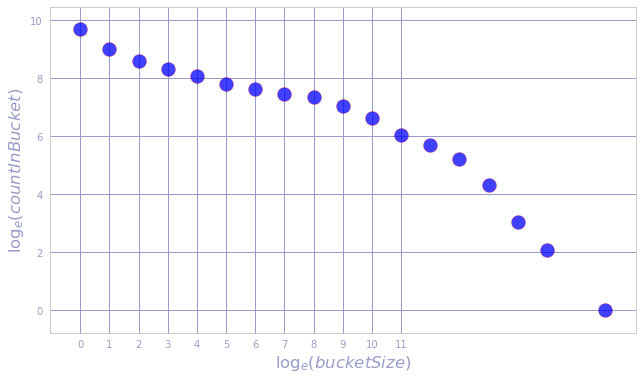

In [34]:
x, y = zip(*feature_counts)
x, y = x, np.log(y)

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999cc9',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999cc9', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999cc9')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 12, 1), np.arange(0, 14, 2))
ax.set_xlabel(r'$\log_e(bucketSize)$'), ax.set_ylabel(r'$\log_e(countInBucket)$')
plt.scatter(x, y, s=14**2, c='blue', edgecolors='red', alpha=0.75)


# Logistic Regression - Cross Validation

In [35]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's initialize our linear regression learner 
lr = LogisticRegression()

# Create an AUC ROC evaluator using the label and predicted columns
bcEval = BinaryClassificationEvaluator(metricName='areaUnderROC')

lr.setStandardization(False)
lr.setMaxIter(200)

# Let's tune over our regularization parameter from 0.01 to 0.10
regParams = [3e-07, 1e-07, 3e-08, 1e-08, 3e-09, 1e-09]
elasticNetParams = [0, 0.5, 1]

cross_validation = pd.DataFrame(columns=['regParam', 'elasticNetParam', 'auc_train', 'auc_dev'])
model_dict = dict()

# loop over tuning parameters
for rp in regParams:
    for enp in elasticNetParams:
        lr.setRegParam(rp)
        lr.setElasticNetParam(enp)
        lr_model = LogisticRegression.fit(lr, hashed_train1)
        model_dict[str((rp, enp))] = lr_model                                          
        auc_train = round(bcEval.evaluate(lr_model.transform(hashed_train1)),6)
        auc_dev = round(bcEval.evaluate(lr_model.transform(hashed_dev1)),6)
        cross_validation = cross_validation.append({'regParam':rp,
                                                    'elasticNetParam':enp,
                                                    'auc_train':auc_train,
                                                    'auc_dev':auc_dev},
                                                   ignore_index=True)
        print('reParam:', rp, '\telasticNetParam:', enp, '\tauc_train:', auc_train, '\tauc_dev:', auc_dev)

reParam: 3e-07 	elasticNetParam: 0 	auc_train: 0.963675 	auc_dev: 0.961811
reParam: 3e-07 	elasticNetParam: 0.5 	auc_train: 0.964405 	auc_dev: 0.962819
reParam: 3e-07 	elasticNetParam: 1 	auc_train: 0.963909 	auc_dev: 0.962505
reParam: 1e-07 	elasticNetParam: 0 	auc_train: 0.965901 	auc_dev: 0.963468
reParam: 1e-07 	elasticNetParam: 0.5 	auc_train: 0.96588 	auc_dev: 0.963823
reParam: 1e-07 	elasticNetParam: 1 	auc_train: 0.965588 	auc_dev: 0.963833
reParam: 3e-08 	elasticNetParam: 0 	auc_train: 0.967279 	auc_dev: 0.963853
reParam: 3e-08 	elasticNetParam: 0.5 	auc_train: 0.96708 	auc_dev: 0.964111
reParam: 3e-08 	elasticNetParam: 1 	auc_train: 0.966815 	auc_dev: 0.964223
reParam: 1e-08 	elasticNetParam: 0 	auc_train: 0.967984 	auc_dev: 0.963791
reParam: 1e-08 	elasticNetParam: 0.5 	auc_train: 0.967982 	auc_dev: 0.964041
reParam: 1e-08 	elasticNetParam: 1 	auc_train: 0.967857 	auc_dev: 0.964093
reParam: 3e-09 	elasticNetParam: 0 	auc_train: 0.968397 	auc_dev: 0.963633
reParam: 3e-09 	ela

Text(0.5,1,'Grid Search on Validation Set')

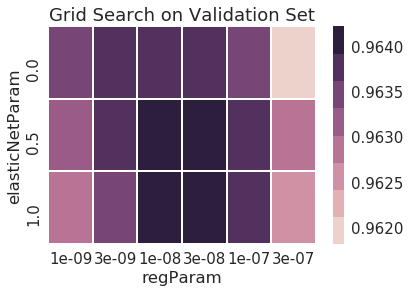

In [36]:
validation_grid = pd.DataFrame(cross_validation).pivot_table(values='auc_dev', index='elasticNetParam', columns='regParam')
sns.heatmap(validation_grid,linecolor='white',linewidths=1, cmap=sns.cubehelix_palette(8)).set_title('Grid Search on Validation Set')

# Best Model

In [37]:
model_dict

{'(1e-07, 0)': LogisticRegression_471bbad66d815651046a,
 '(1e-07, 0.5)': LogisticRegression_471bbad66d815651046a,
 '(1e-07, 1)': LogisticRegression_471bbad66d815651046a,
 '(1e-08, 0)': LogisticRegression_471bbad66d815651046a,
 '(1e-08, 0.5)': LogisticRegression_471bbad66d815651046a,
 '(1e-08, 1)': LogisticRegression_471bbad66d815651046a,
 '(1e-09, 0)': LogisticRegression_471bbad66d815651046a,
 '(1e-09, 0.5)': LogisticRegression_471bbad66d815651046a,
 '(1e-09, 1)': LogisticRegression_471bbad66d815651046a,
 '(3e-07, 0)': LogisticRegression_471bbad66d815651046a,
 '(3e-07, 0.5)': LogisticRegression_471bbad66d815651046a,
 '(3e-07, 1)': LogisticRegression_471bbad66d815651046a,
 '(3e-08, 0)': LogisticRegression_471bbad66d815651046a,
 '(3e-08, 0.5)': LogisticRegression_471bbad66d815651046a,
 '(3e-08, 1)': LogisticRegression_471bbad66d815651046a,
 '(3e-09, 0)': LogisticRegression_471bbad66d815651046a,
 '(3e-09, 0.5)': LogisticRegression_471bbad66d815651046a,
 '(3e-09, 1)': LogisticRegression_47

In [38]:
best_rp = 3e-08
best_enp = 1

lr_best_model = model_dict['('+str(best_rp)+', '+str(best_enp)+')']
                                 
auc_train = round(bcEval.evaluate(lr_best_model.transform(hashed_train1)),6)
auc_dev = round(bcEval.evaluate(lr_best_model.transform(hashed_dev1)),6)
auc_modeling_next = round(bcEval.evaluate(lr_best_model.transform(hashed_modeling2)),6)

print('reParam:', best_rp,
      '\telasticNetParam:', best_enp,
      '\tauc_train:', auc_train,
      '\tauc_dev:', auc_dev,
      '\tauc_modeling_next:', auc_modeling_next)

reParam: 3e-08 	elasticNetParam: 1 	auc_train: 0.966815 	auc_dev: 0.964223 	auc_modeling_next: 0.965345


In [39]:
hashed_train1.unpersist()
hashed_dev1.unpersist()

DataFrame[id: bigint, label: int, features: vector]

# Scoring

## Prediction on modeling2 dataset (50% of original training set)

In [40]:
# Apply best model to generate predictions
prediction_modeling2 = lr_best_model.transform(hashed_modeling2).cache()
prediction_modeling2.show(1, truncate=False)

+-------+-----+---------------------------------------------------------------------------------------------------------------------+--------------------------------------+-----------------------------------------+----------+
|id     |label|features                                                                                                             |rawPrediction                         |probability                              |prediction|
+-------+-----+---------------------------------------------------------------------------------------------------------------------+--------------------------------------+-----------------------------------------+----------+
|1039498|0    |(262144,[12503,14706,36901,68395,98169,103637,118293,128335,139989,208714],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|[9.099537331056421,-9.099537331056421]|[0.9998882949946568,1.117050053431097E-4]|0.0       |
+-------+-----+---------------------------------------------------------------------------------

In [41]:
# Estimating the AUC score on modeling_next dataset
auc_modeling_next = round(bcEval.evaluate(prediction_modeling2),6)
print('Estimated AUC modeling next:', round(auc_modeling_next,6))

Estimated AUC modeling next: 0.965345


In [42]:
# Free memory
hashed_modeling2.unpersist()

DataFrame[id: bigint, label: int, features: vector]

In [43]:
# UDF to extract probability of positive class
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, StructType

def get_pred(probability):

    """
    Returns the probability of a converted click
    Extracts the second element of vector probability
    
    Args:
        probability -- vector of two elements (probability for 0 and 1)
    """
    return(round(probability.toArray().tolist()[1],6))

get_pred_udf = udf(get_pred, DoubleType())

In [44]:
# New Feature DataFrame
f_lr_hash_modeling2 = (prediction_modeling2
                       .withColumn('f_lr_hash_inter2_2p18_noip', get_pred_udf(col('probability')))
                       .select('id', 'f_lr_hash_inter2_2p18_noip'))
f_lr_hash_modeling2.show(3)

+-------+--------------------------+
|     id|f_lr_hash_inter2_2p18_noip|
+-------+--------------------------+
|1039498|                   1.12E-4|
|1039947|                   1.12E-4|
|1863448|                   1.25E-4|
+-------+--------------------------+
only showing top 3 rows



In [45]:
# Free memory
prediction_modeling2.unpersist()

DataFrame[id: bigint, label: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [46]:
f_lr_hash_modeling2.cache()

DataFrame[id: bigint, f_lr_hash_inter2_2p18_noip: double]

In [47]:
# Saving new feature to disk
(f_lr_hash_modeling2
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"logisitc_regression/lasso/f_lr_hash_inter2_2p18_noip_modeling2_split", compression="None"))

## Prediction on test set

In [48]:
# Apply best model to generate predictions
prediction_test = lr_best_model.transform(hashed_test)
prediction_test.show(1, truncate=False)

+---+-----+-----------------------------------------------------------------------------------------------------------------------+--------------------------------------+------------------------------------------+----------+
|id |label|features                                                                                                               |rawPrediction                         |probability                               |prediction|
+---+-----+-----------------------------------------------------------------------------------------------------------------------+--------------------------------------+------------------------------------------+----------+
|0  |-1   |(262144,[12503,73061,74731,101357,164359,177261,197416,218491,228176,240775],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|[7.655487389750511,-7.655487389750511]|[0.9995267849950147,4.7321500498543104E-4]|0.0       |
+---+-----+-----------------------------------------------------------------------------------------

In [49]:
# UDF to extract probability of positive class
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, StructType

def get_pred(probability):

    """
    Returns the probability of a converted click
    Extracts the second element of vector probability
    
    Args:
        probability -- vector of two elements (probability for 0 and 1)
    """
    return(round(probability.toArray().tolist()[1],6))

get_pred_udf = udf(get_pred, DoubleType())

In [50]:
# New Feature DataFrame
f_lr_hash_test = (prediction_test
                  .withColumn('f_lr_hash_inter2_2p18_noip', get_pred_udf(col('probability')))
                  .select('id', 'f_lr_hash_inter2_2p18_noip'))
f_lr_hash_test.show(3)

+---+--------------------------+
| id|f_lr_hash_inter2_2p18_noip|
+---+--------------------------+
|  0|                   4.73E-4|
|  1|                    5.7E-4|
|  2|                   1.15E-4|
+---+--------------------------+
only showing top 3 rows



In [51]:
import pyspark.sql.functions as func

f_lr_hash_test.groupBy().agg(func.max(col('id'))).show()

+------------+
|     max(id)|
+------------+
|120260237348|
+------------+



In [53]:
# Saving new feature to disk
(f_lr_hash_test
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"logisitc_regression/lasso/f_lr_hash_inter2_2p18_noip_test", compression="None"))

In [52]:
# Saving new feature to disk
(f_lr_hash_test
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"logisitc_regression/lasso/f_lr_hash_inter2_2p18_noip_test_split", compression="None"))